## Preparación para el Modelado

Con base en la exploración inicial del dataset de características derivadas del intervalo RR, se tomaron las siguientes decisiones para mejorar el rendimiento del modelo de clasificación:

### 1. Balanceo de Clases con SMOTE
Se observó un fuerte desbalance entre las clases: la mayoría de las muestras corresponden a ritmo normal (N) y solo unas pocas a fibrilación auricular (A). Para mitigar este desequilibrio y evitar que el modelo favorezca la clase mayoritaria, se aplicará la técnica **SMOTE (Synthetic Minority Over-sampling Technique)**, generando ejemplos sintéticos de la clase minoritaria.

### 2. Eliminación de Outliers
Se detectaron valores extremos en las variables `mean_rr`, `std_rr` y `kurt_rr`, con máximos considerablemente alejados del rango intercuartílico. Estos outliers pueden afectar negativamente el proceso de entrenamiento. Se utilizará la técnica del **IQR (Interquartile Range)** para identificar y eliminar registros atípicos por variable.

### 3. Ajuste de Hiperparámetros
Una vez establecido el modelo base (Random Forest), se realizará una búsqueda sistemática de hiperparámetros utilizando **GridSearchCV**.




## Justificación del uso de Random Forest

Random Forest es una opción adecuada para este problema porque puede manejar relaciones no lineales entre las variables estadísticas del intervalo RR sin necesidad de preprocesamiento complejo. Es resistente al ruido y a valores atípicos, lo que es útil en datos fisiológicos. Además, al combinar múltiples árboles, reduce el riesgo de sobreajuste y permite estimar la importancia de las variables, lo cual es útil para interpretar el modelo y guiar posibles mejoras.


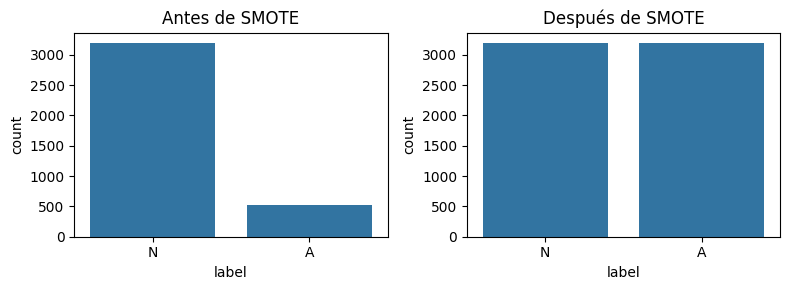

Fitting 5 folds for each of 48 candidates, totalling 240 fits


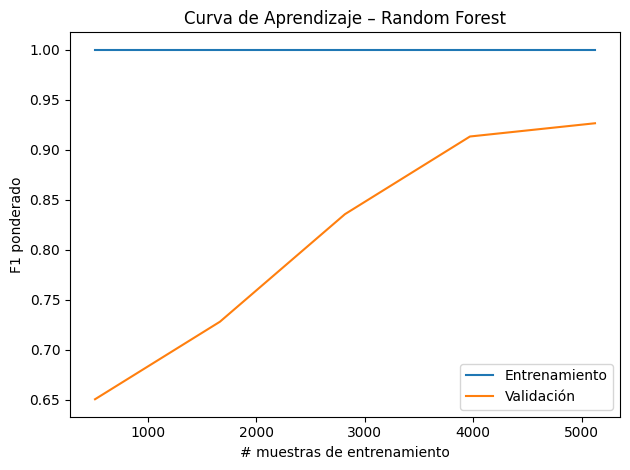

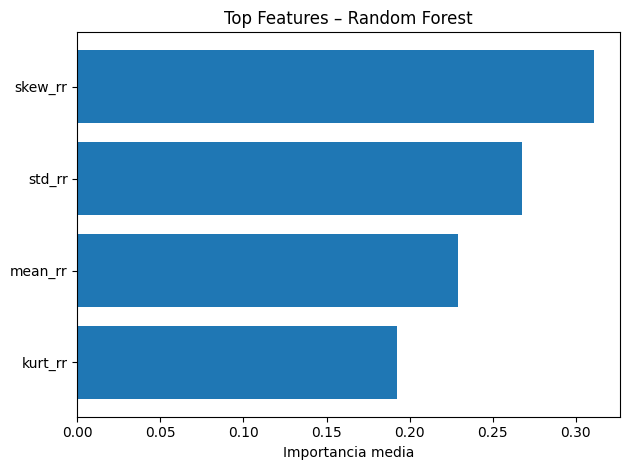


Mejores hiperparámetros encontrados:
{'class_weight': None, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

Reporte por clase:
              precision    recall  f1-score   support

           A       0.57      0.76      0.65       130
           N       0.96      0.91      0.93       801

    accuracy                           0.89       931
   macro avg       0.77      0.83      0.79       931
weighted avg       0.91      0.89      0.89       931



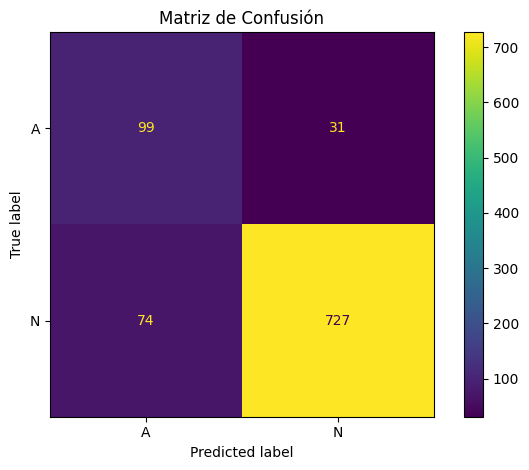

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, ConfusionMatrixDisplay
)
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Cargar datos
df = pd.read_csv("../data/ecg_rr_features_curado.csv")

# Eliminar outliers por IQR para cada variable numérica
def eliminar_outliers_iqr(df, columnas):
    df_filtrado = df.copy()
    for col in columnas:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df_filtrado = df_filtrado[(df_filtrado[col] >= lower) & (df_filtrado[col] <= upper)]
    return df_filtrado

columnas_num = ["mean_rr", "std_rr", "skew_rr", "kurt_rr"]
df = eliminar_outliers_iqr(df, columnas_num)

# Separar características y etiquetas
X = df.drop(columns=["record", "label"])
y = df["label"]

# División en conjuntos de entrenamiento y prueba, y aplicación de SMOTE
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Distribución de clases antes y después de SMOTE
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
sns.countplot(x=y_train, ax=ax[0])
ax[0].set_title("Antes de SMOTE")
sns.countplot(x=y_train_smote, ax=ax[1])
ax[1].set_title("Después de SMOTE")
plt.tight_layout()
plt.show()

# GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'class_weight': [None, 'balanced']
}

grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train_smote, y_train_smote)
clf = grid.best_estimator_

# Curva de aprendizaje
train_sizes, tr_scores, val_scores = learning_curve(
    clf, X_train_smote, y_train_smote,
    cv=5, scoring="f1_weighted", n_jobs=-1
)
plt.plot(train_sizes, tr_scores.mean(1), label="Entrenamiento")
plt.plot(train_sizes, val_scores.mean(1), label="Validación")
plt.xlabel("# muestras de entrenamiento")
plt.ylabel("F1 ponderado")
plt.title("Curva de Aprendizaje – Random Forest")
plt.legend()
plt.tight_layout()
plt.show()

# Importancia de variables
importances = clf.feature_importances_
feat_names = X.columns
idx = np.argsort(importances)[::-1][:15]

plt.barh(range(len(idx)), importances[idx][::-1])
plt.yticks(range(len(idx)), feat_names[idx][::-1])
plt.xlabel("Importancia media")
plt.title("Top Features – Random Forest")
plt.tight_layout()
plt.show()

# Evaluación
y_pred = clf.predict(X_test)

print("\nMejores hiperparámetros encontrados:")
print(grid.best_params_)
print("\nReporte por clase:")
print(classification_report(y_test, y_pred))

# Matriz de confusión
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Matriz de Confusión")
plt.tight_layout()
plt.show()

## Evaluación del Modelo: Análisis y Mejoras

### Descripción de métricas y relevancia médica

- **Accuracy (Exactitud):**  
  89%. Mide el porcentaje total de predicciones correctas. Es útil como visión general, pero puede ser engañosa en datasets desbalanceados como este (801 N vs. 130 A).

- **Precision (Clase A: 0.57):**  
  Solo el 57% de los casos que el modelo predijo como AFib eran realmente AFib.  
  En medicina, esto implica que **hay falsos positivos**, pero no es lo más grave clínicamente.

- **Recall (Clase A: 0.76):**  
  El 76% de los verdaderos casos de AFib fueron correctamente detectados.  
  Esta métrica es **clave en este contexto médico**, ya que no detectar AFib puede tener consecuencias graves. Es preferible equivocarse de más (falsos positivos) que dejar pasar un caso real.

- **F1-score (Clase A: 0.65):**  
  Equilibra precisión y recall. El valor indica que el modelo aún tiene margen de mejora, especialmente para reducir los falsos negativos **sin sacrificar demasiado la precisión**.

- **Matriz de confusión:**  
  - **Falsos negativos:** 31 casos de AFib fueron clasificados como normales.
  - **Falsos positivos:** 74 casos normales fueron clasificados como AFib.
  Esto indica un sesgo levemente conservador, lo cual **no es tan negativo médicamente** si se prioriza la detección temprana.

---

### Cosas positivas

- Buen **recall para la clase A (0.76)**, lo cual es fundamental.
- Alto **recall y precisión en la clase N**, lo que demuestra robustez en ritmos normales.
- La **curva de aprendizaje** muestra que el modelo **aún mejora con más datos**, y que no está sobreajustado (la curva de validación sigue subiendo).
- La distribución de **importancia de variables** es razonable: `skew_rr` y `std_rr` destacan, indicando que las irregularidades en el ritmo tienen peso en el diagnóstico.

---

### Propuestas de mejora

1. **Aumentar recall de clase A (menos falsos negativos).**

2. **Reducir falsos positivos (mejorar precisión).**

3. **Mejorar input del modelo:**
   - Crear nuevas variables como:
     - `cv_rr = std_rr / mean_rr` (coeficiente de variación)
     - `iqr_rr`, `range_rr`, `median_rr`
   - Realizar **transformaciones logarítmicas o normalizaciones robustas** en `kurt_rr` y `skew_rr`, que tienden a tener outliers fuertes.

4. **Simplificación del modelo:**
   - Aunque `skew_rr` lidera en importancia, `kurt_rr` es la menos informativa. Se puede intentar entrenar un modelo con solo las 2 o 3 variables más relevantes y ver si se mantiene el rendimiento.

5. **Evaluación en otras métricas clínicas:**
   - Usar **curvas ROC** o **curvas precision-recall ajustadas** para seleccionar el mejor punto de operación del modelo según necesidades clínicas reales.

---

### Conclusión

El modelo logra un balance sólido entre precisión y sensibilidad, especialmente con un **buen recall en fibrilación auricular**, que es el objetivo principal. Todavía hay margen para reducir los errores (falsos negativos y positivos), ya sea mediante ajuste de umbrales, mejoras de input o modelos más especializados. El modelo es funcional y clínicamente útil, pero puede volverse aún más fiable con refinamientos.

